In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.kde import KDEUnivariate

In [2]:
# Đọc tệp shapefile sử dụng GeoPandas
gdf = gpd.read_file('gadm41_VNM_2.shp')
# Lọc tỉnh lấy TP.HCM
gdf_hcm = gdf[gdf['NAME_1'] == 'Há»\x93 ChÃ\xad Minh']
print(gdf_hcm['VARNAME_2'].unique())

['Binh Chanh' 'Binh Tan' 'Binh Thanh' 'Can Gio' 'Cu Chi' 'Go Vap'
 'Hoc Mon' 'Nha Be' 'Phu Nhuan' 'District 1' 'District 10' 'District 11'
 'District 12' 'District 2' 'District 3' 'District 4' 'District 5'
 'District 6' 'District 7' 'District 8' 'District 9' 'Tan Binh' 'Tan Phu'
 'Thu Duc']


In [3]:
# Đổi tên cột chứa quận thành "District" để đồng nhất với tệp dữ liệu
gdf_hcm = gdf_hcm.rename(columns={'VARNAME_2': 'District'})

# Thay đổi format của dữ liệu tên quận để đồng nhất với tệp dữ liệu
replace_dict = {'Binh Chanh':'binh-chanh', 'Binh Tan' : 'binh-tan','Binh Thanh':'binh-thanh', 'Can Gio':'can-gio', 
 'Cu Chi':'cu-chi', 'Go Vap':'go-vap', 'Hoc Mon':'hoc-mon', 'Nha Be':'nha-be', 'Phu Nhuan':'phu-nhuan', 
 'District 1':'quan-1', 'District 10':'quan-10', 'District 11':'quan-11', 'District 12':'quan-12', 'District 2':'quan-2', 
 'District 3':'quan-3', 'District 4':'quan-4', 'District 5':'quan-5', 'District 6':'quan-6', 'District 7':'quan-7', 
 'District 8':'quan-8', 'District 9':'quan-9', 'Tan Binh':'tan-binh',  'Tan Phu':'tan-phu', 'Thu Duc':'thu-duc'}
gdf_hcm['District'] = gdf_hcm['District'].replace(replace_dict)

In [45]:
# Đọc tệp dữ liệu đã được làm sạch
df=pd.read_csv('clean_data.csv')

# Chuẩn bị dữ liệu số lượng nhà bán theo quận
district_counts = df['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Counts']
district_counts

,District,Counts
0,go-vap,837
1,binh-tan,809
2,thu-duc,604
3,tan-binh,603
4,binh-thanh,601
5,tan-phu,469
6,quan-9,312
7,phu-nhuan,264
8,quan-7,213
9,quan-12,203


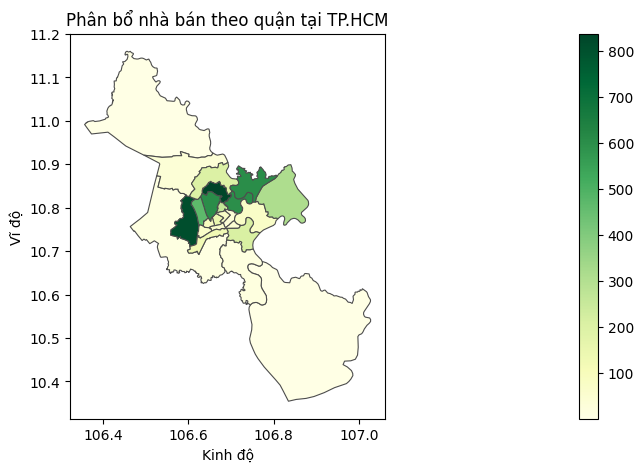

In [42]:
# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(district_counts, on='District')

# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize=(50, 5))

gdf.plot(column='Counts', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)

plt.title('Phân bổ nhà bán theo quận tại TP.HCM')
plt.xlabel('Kinh độ')
plt.ylabel('Vĩ độ')
plt.show()

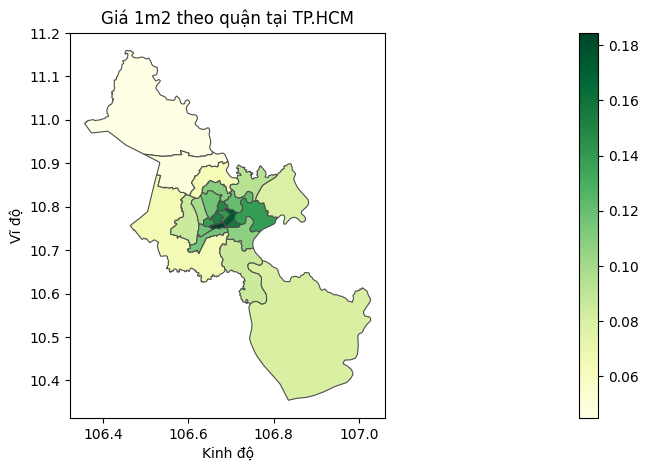

In [52]:
# Nhóm dữ liệu theo cột 'District' và tính giá trị trung bình của 'Price_per_sqm' cho mỗi quận
price_per_sqm_mean_by_district = df.groupby('District')['Price_per_sqm'].mean().reset_index()

# Đổi tên cột để rõ ràng hơn
price_per_sqm_mean_by_district.rename(columns={'Price_per_sqm': 'price_per_sqm_mean'}, inplace=True)

# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(price_per_sqm_mean_by_district, on='District')

# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize=(50, 5))

gdf.plot(column='price_per_sqm_mean', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)

plt.title('Giá 1m2 theo quận tại TP.HCM')
plt.xlabel('Kinh độ')
plt.ylabel('Vĩ độ')
plt.show()

In [44]:
# Tính KDE
kde = KDEUnivariate(df['District_encoded'])
kde.fit(bw='scott')

# Vẽ đồ thị
# plt.plot(kde.support, kde.density, label='KDE with statsmodels')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.title('Kernel Density Estimation')
# plt.legend()
# plt.show()

print(kde.density)

[0.00045565 0.00045175 0.00044788 ... 0.0004676  0.00046358 0.00045959]


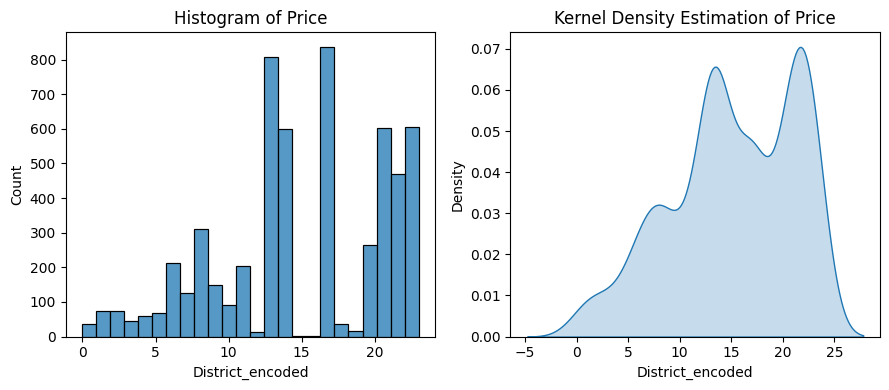

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
# Histogram
sns.histplot(df['District_encoded'], ax=axes[0], bins = 24)
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('District_encoded')
axes[0].set_ylabel('Count')

# KDE Plot
sns.kdeplot(df['District_encoded'], bw_adjust = 1.5, ax=axes[1],  fill=True, cmap='viridis')
axes[1].set_title('Kernel Density Estimation of Price')
axes[1].set_xlabel('District_encoded')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()